<a href="https://colab.research.google.com/github/Man0j3/Brain-Tumor-detection/blob/main/brainmri_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import chain
import random
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose,MaxPooling2D, concatenate,UpSampling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Introduction
In my previous notebook, I trained a traditional UNet like model from scratch for brain tumor segmentation. You can find the same [here](http://https://www.kaggle.com/code/shashank069/brainmri-image-segmentation). In this version, I'll train an Attention UNet like model. You can find more information about it [here](http://https://arxiv.org/abs/1804.03999). Attention UNet is expected to outperform the traditional UNet network. If you're familiar with attention networks used in NLP, you'll note that the idea behind using attention in CNNs is same. Essentially, by adding an attention block (I urge you to check the link) we'll compell the network to give more weightage to tumor regions in MRI images, which'll ultimately lead to improved performance.

# Data preparation
The data has 110 directories each containing MRI scans from 110 different patients. All directories, however, don't necessarily have the same number of images. Each image represents a 2D slice of the brain, and the aim is to identify tumor regions in these 2D images. Note that the tumor and the brain are 3D, and any slice is a sectional representation. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH ="/content/drive/MyDrive/kaggle_3m_1/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
patient=[]
for d in os.listdir(DATA_PATH):
    if d!='data.csv' and d!='README.md':
        patient.append(d)

I'll ensure that different images of a single patient aren't part of training and validation sets. This might lead to data leakage and an overestimated performance of the final model.

In [4]:
def create_dataset(start,end,dataset_type):
    train_files = []
    mask_files=[]
    c=0
    for i,p in enumerate(patient[start:end]):
        vals=[]
        mask_files.append(glob(DATA_PATH+p+'/*_mask*'))
        for m in mask_files[i]:
            vals.append(np.max(cv2.imread(m)))
        if max(vals)==0:
            print(f'patient { p } has no tumor')
            c+=1
    if c==0:
        print(f'Each patient in {dataset_type} dataset has brain tumor')
    mask_files=list(chain.from_iterable(mask_files))
    for m in mask_files:
        train_files.append(m.replace('_mask',''))
    df = pd.DataFrame(data={"filepath": train_files, 'mask' : mask_files})
    return df

In [5]:
#lenghts for training,validation and testing datasets
a=int(0.9*len(patient))
b=int(0.8*a)

In [6]:
#Creating datasets and finding whether there's any patient with no tumor in the provided data
df_train=create_dataset(0,b,'training')
df_val=create_dataset(b,a,'validation')
df_test=create_dataset(a,len(patient),'testing')

Each patient in training dataset has brain tumor
Each patient in validation dataset has brain tumor
Each patient in testing dataset has brain tumor


Each image loaded from filepath column has a pixel range of 0-255, while the mask(label) images have binary pixel values of 0 or 255. You can call the below function by passing "filepath" or "mask" as argument for variable col.
1. Filepath will return pixel value counts of a random image from the dataset
2. Mask will return pixel value counts of a random mask(label) image from the dataset

In [7]:
#function to view pixel range of an image from the dataset. Note: The function selects a random image everytime it's called
def pixel_value_counts(col,end):
    p=np.random.randint(0,end)
    img=cv2.imread(df_train[col].loc[p])
    unique, counts = np.unique(img, return_counts=True)
    print(f'showing pixel value counts for image {p}')
    print(np.asarray((unique, counts)).T)
#pixel_value_counts('filepath',len(df_train)) #can use test and validation sets too
pixel_value_counts('mask',len(df_train))

showing pixel value counts for image 160
[[     0 196608]]


In [8]:
#Marking masks in test dataset as 0 and 1. Will be useful while making final plots
for i in range(0,len(df_test)):
    arr=np.where(cv2.imread(df_test['mask'].loc[i])==255,1,0) 
    v=np.max(arr)
    if v==1:
        df_test.loc[i,'res']=1
    else:
        df_test.loc[i,'res']=0

In [9]:
df_train.sample(5,random_state=42)

,filepath,mask
30,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_494...,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_494...
181,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...
223,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...
185,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...
211,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...


The column filepath consists of MRI images of a patient,while mask images define only tumor regions in those images. For our problem, we are going to use images from filepath to segment the regions that have tumor. Essentially, filepath images are our training features and mask images (label) are our target values.

# Plotting MRI scans for a random patient

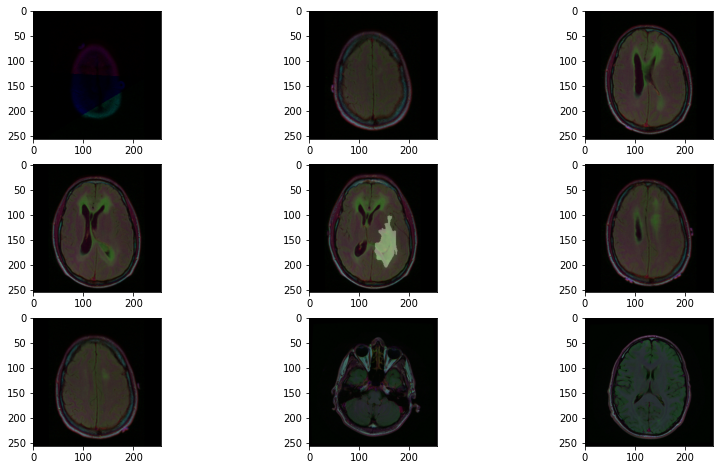

In [10]:
f,ax=plt.subplots(3,3,figsize=(14,8))
ax=ax.flatten()
for j in range(0,9):
    i=53+j
    img=cv2.imread(df_train['filepath'].loc[i])
    msk=cv2.imread(df_train['mask'].loc[i])
    ax[j].imshow(msk)
    ax[j].imshow(img,alpha=0.7)
plt.show()

# Data Generator

In [11]:
#Function to create image datasets using keras flow_from_dataframe
def img_dataset(df_inp,path_img,path_mask,aug_args,batch):
    img_gen=ImageDataGenerator(rescale=1./255.,**aug_args)
    df_img = img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_img,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode='rgb',
                                         seed=1,
                                     target_size=(256,256))
    df_mask=img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_mask,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode='grayscale',
                                        seed=1,
                                     target_size=(256,256))
    data_gen = zip(df_img,df_mask)
    return data_gen

# Loss Functions
In the previous version, I trained the model using both weighted cross entropy and dice loss, and the latter performed better. Hence,for Attention UNet I'll stick to only Dice loss.

In [12]:
def dice_loss(y_true, y_pred):
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersec=K.sum(y_true* y_pred)
    return (-((2* intersec + 0.1) / (K.sum(y_true) + K.sum(y_pred) + 0.1)))

def iou(y_true,y_pred):
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersec + 0.1) / (union- intersec + 0.1)
    return iou

# Model
For modelling, we are going to implement an Attnetion UNet like network from scratch. You can visit this [link](http://https://arxiv.org/abs/1804.03999) for more information on Attention UNet.

In [13]:
def conv_block(inp,filters):
    x=Conv2D(filters,(3,3),padding='same',activation='relu')(inp)
    x=Conv2D(filters,(3,3),padding='same')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    return x

def encoder_block(inp,filters):
    x=conv_block(inp,filters)
    p=MaxPooling2D(pool_size=(2,2))(x)
    return x,p

def attention_block(l_layer,h_layer): #Attention Block
    phi=Conv2D(h_layer.shape[-1],(1,1),padding='same')(l_layer)
    theta=Conv2D(h_layer.shape[-1],(1,1),strides=(2,2),padding='same')(h_layer)
    x=tf.keras.layers.add([phi,theta])
    x=Activation('relu')(x)
    x=Conv2D(1,(1,1),padding='same',activation='sigmoid')(x)
    x=UpSampling2D(size=(2,2))(x)
    x=tf.keras.layers.multiply([h_layer,x])
    x=BatchNormalization(axis=3)(x)
    return x
    
def decoder_block(inp,filters,concat_layer):
    x=Conv2DTranspose(filters,(2,2),strides=(2,2),padding='same')(inp)
    concat_layer=attention_block(inp,concat_layer)
    x=concatenate([x,concat_layer])
    x=conv_block(x,filters)
    return x

In [14]:
inputs=Input((256,256,3))
d1,p1=encoder_block(inputs,64)
d2,p2=encoder_block(p1,128)
d3,p3=encoder_block(p2,256)
d4,p4=encoder_block(p3,512)
b1=conv_block(p4,1024)
e2=decoder_block(b1,512,d4)
e3=decoder_block(e2,256,d3)
e4=decoder_block(e3,128,d2)
e5=decoder_block(e4,64,d1)
outputs = Conv2D(1, (1,1),activation="sigmoid")(e5)
model=Model(inputs=[inputs], outputs=[outputs],name='AttnetionUnet')

In [15]:
model.summary()

Model: "AttnetionUnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                     

In [16]:
#Data augmentation arguments for training set
augmentation_args=dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            fill_mode='nearest')
batch=32

In [17]:
def train_model(model,save_name,loss_func):
    opt = Adam(learning_rate=1e-4, epsilon=None, amsgrad=False,beta_1=0.9,beta_2=0.99)
    model.compile(optimizer=opt, loss=loss_func,metrics=[iou])
    callbacks = [ModelCheckpoint(save_name,verbose=1,save_best_only=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=5, min_lr=1e-6),
                EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]
    train=img_dataset(df_train,'filepath','mask',augmentation_args,batch)
    val=img_dataset(df_val,'filepath','mask',dict(),batch)

    history = model.fit(train, 
                                  validation_data=val,
                                  steps_per_epoch=len(df_train)/batch, 
                                  validation_steps=len(df_val)/batch, 
                                  epochs = 5,
                                 callbacks=callbacks)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Training Loss Curve")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Found 260 validated image filenames.
Found 260 validated image filenames.
Found 87 validated image filenames.
Found 87 validated image filenames.
Epoch 1/5
9/8 [=================================] - ETA: -168s - loss: -0.0456 - iou: 0.0223
Epoch 1: val_loss improved from inf to -0.01841, saving model to unet_wts1.hdf5
8/8 [==============================] - 1946s 241s/step - loss: -0.0456 - iou: 0.0223 - val_loss: -0.0184 - val_iou: 0.0090 - lr: 1.0000e-04
Epoch 2/5
9/8 [=================================] - ETA: -169s - loss: -0.0790 - iou: 0.0387
Epoch 2: val_loss did not improve from -0.01841
8/8 [==============================] - 1931s 241s/step - loss: -0.0790 - iou: 0.0387 - val_loss: -0.0180 - val_iou: 0.0096 - lr: 1.0000e-04
Epoch 3/5
9/8 [=================================] - ETA: -170s - loss: -0.1170 - iou: 0.0595
Epoch 3: val_loss improved from -0.01841 to -0.01945, saving model to unet_wts1.hdf5
8/8 [==============================] - 1986s 248s/step - loss: -0.1170 - iou: 0.05

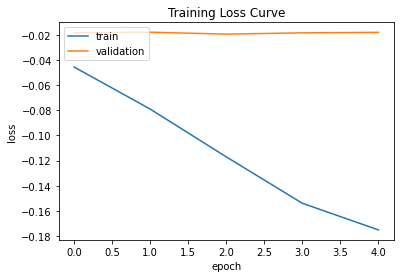

In [18]:
train_model(model,'unet_wts1.hdf5',dice_loss)

# Evaluation

In [19]:
def eval_model(model_wts,custom_objects):
    model = load_model(model_wts,custom_objects=custom_objects)
    test=img_dataset(df_test[['filepath','mask']],'filepath','mask',dict(),32)
    model.evaluate(test,steps=len(df_test)/32)
    a=np.random.RandomState(seed=42)
    indexes=a.randint(1,len(df_test[df_test['res']==1]),10)
    for i in indexes:
        img = cv2.imread(df_test[df_test['res']==1].reset_index().loc[i,'filepath'])
        img = cv2.resize(img ,(256, 256))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred=model.predict(img)

        plt.figure(figsize=(12,12))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(cv2.imread(df_test[df_test['res']==1].reset_index().loc[i,'mask'])))
        plt.title('Original Mask')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

1.Attnetion Unet with dice loss

Found 53 validated image filenames.
Found 53 validated image filenames.
1/1 [==============================] - 94s 56s/step - loss: -0.0261 - iou: 0.0138   


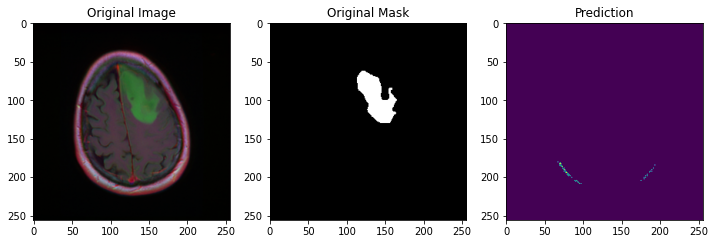

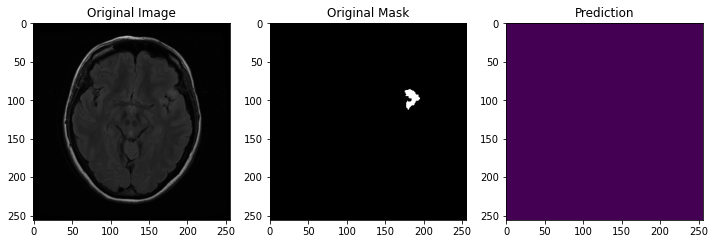

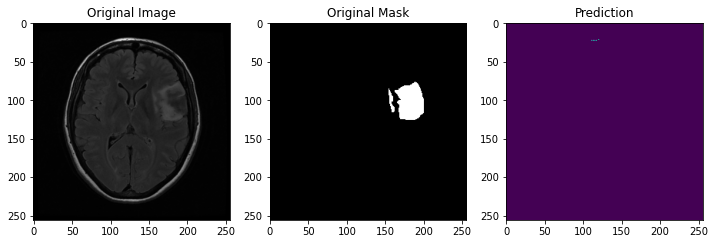

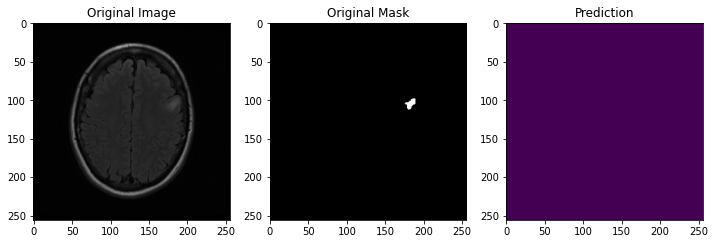

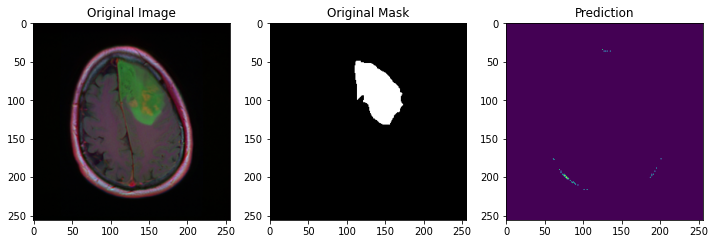

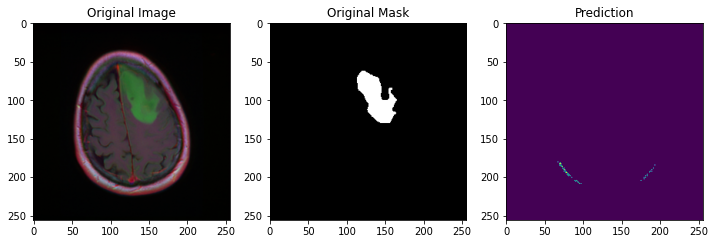

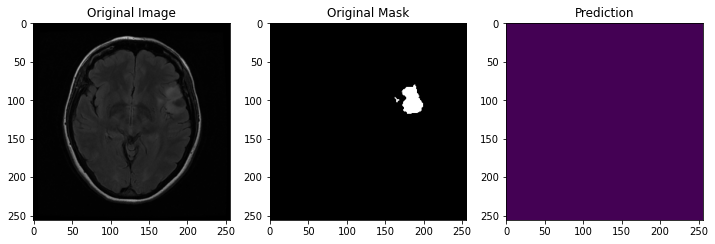

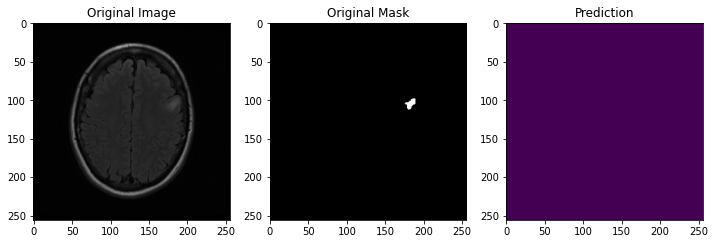

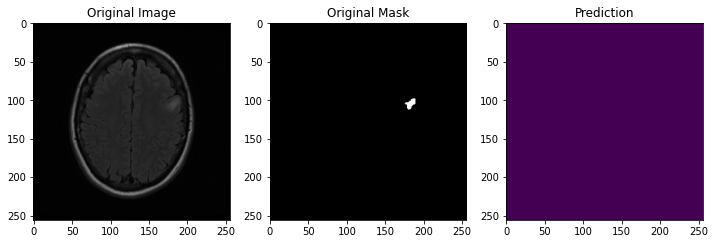

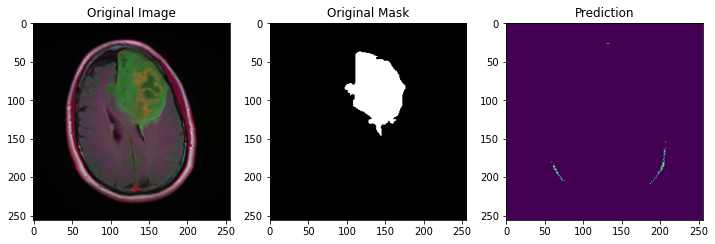

In [20]:
eval_model('unet_wts1.hdf5',{'dice_loss':dice_loss,'iou':iou})

# Observations:
As expected, Attention UNet performed better than UNet. 
You can verify the same by comparing the IOU and Dice scores from the previous version. Do comment your suggestions for any further improvements. As the training loss curve doesn't point to overfitting, I belive that training the models, both UNet and Attention UNet, for more epochs will elevate their performances.